# Step 1: Install Dependencies (if needed)

In [ ]:
import os
!!git clone https://github.com/Maria-Elisa-M/BW_prediction_keypoint.git
os.chdir('BW_prediction_keypoint')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# uncomment to install
# !pip install ultralytics scikit-image tifffile pandas matplotlib opencv-python-headless imagecodecs

# Step 2: Import Required Libraries

In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import skimage.io
import matplotlib.pyplot as plt
import tifffile
from ultralytics import YOLO
from skimage.measure import label, regionprops
from skimage.transform import rotate
from scipy import ndimage as nd
import math
import imagecodecs

#Step 3: Define File Paths

In [ ]:
main_dir = '/depth'
# Define paths for images and YOLO model
image_path = os.path.join(main_dir, 'Images','4580_20220815_094641_depth_frame_0.png')  # Update with your file path
depth_path = os.path.join(main_dir, 'Images','4580_20220815_094641_depth_frame_0.tif')
model_path = os.path.join(main_dir, 'segment/train/stream3/train/weights/best.pt')

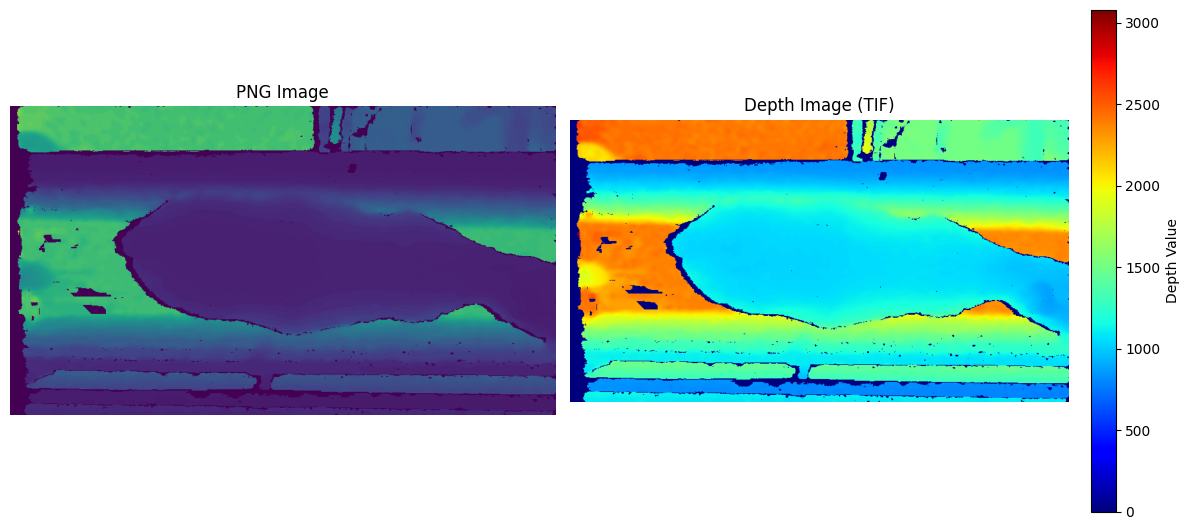

In [ ]:
# Load the images
depth_image = tifffile.imread(depth_path)  # Load depth .tif image
png_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load .png image in grayscale
# Plot both images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the PNG image
axes[0].imshow(png_image)
axes[0].set_title("PNG Image")
axes[0].axis("off")  # Hide axes

# Plot the Depth TIF image with 'jet' colormap
im = axes[1].imshow(depth_image, cmap="jet")
axes[1].set_title("Depth Image (TIF)")
axes[1].axis("off")  # Hide axes

# Add a colorbar for depth visualization
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label="Depth Value")

plt.tight_layout()
plt.show()

#Step 4: Run YOLO for Mask Prediction and Plot Results


image 1/1 /content/drive/MyDrive/guilherme/depth/Images/4580_20220815_094641_depth_frame_0.png: 384x672 1 cow, 405.7ms
Speed: 16.3ms preprocess, 405.7ms inference, 38.6ms postprocess per image at shape (1, 3, 384, 672)


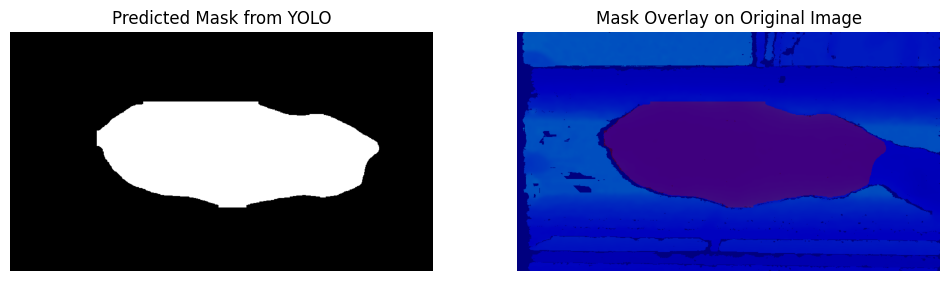

In [ ]:
# Load YOLO model
model = YOLO(model_path)

# Run YOLO inference
results = model(image_path)[0]

# Load original image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

# Create an empty mask
mask = np.zeros((results.orig_img.shape[0], results.orig_img.shape[1]), dtype=np.uint8)

# Extract and fill only the largest detected object
if results.masks is not None:
    largest_area = 0
    largest_contour = None
    for seg in results.masks.xy:
        pts = np.array(seg, dtype=np.int32)
        area = cv2.contourArea(pts)
        if area > largest_area:
            largest_area = area
            largest_contour = pts

    if largest_contour is not None:
        cv2.fillPoly(mask, [largest_contour], 255)

# Plot YOLO Predicted Mask and Overlay
plt.figure(figsize=(12,6))

# Subplot 1: Predicted Mask
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.title("Predicted Mask from YOLO")
plt.axis("off")

# Subplot 2: Original Image with Mask Overlay
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)
plt.imshow(mask, cmap="jet", alpha=0.5)  # Overlay mask with transparency
plt.title("Mask Overlay on Original Image")
plt.axis("off")

plt.show()

#Step 5: Compute and Plot Mask Widths (Excluding First & Last Keypoints)

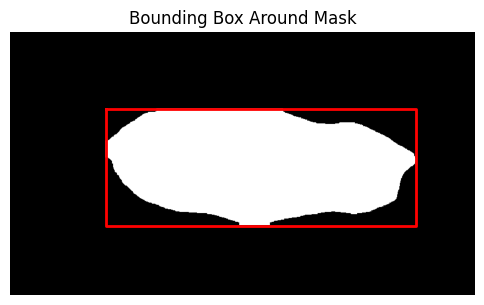

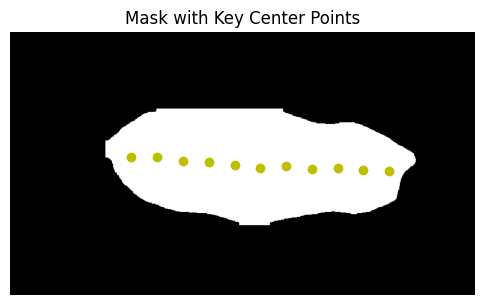

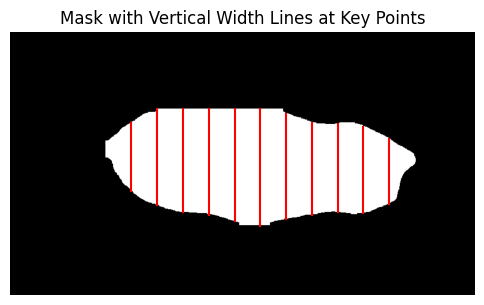

In [ ]:
def calculate_vertical_center_points(mask, num_points=13):
    """
    Compute evenly spaced vertical center points along the mask.
    Excludes the first and last keypoints (keypoints 1 and 13).
    """
    labeled_mask = label(mask)
    properties = regionprops(labeled_mask)

    if not properties:
        return []

    minr, minc, maxr, maxc = properties[0].bbox  # Bounding box
    spaced_columns = np.linspace(minc, maxc - 1, num=num_points, dtype=int)[1:-1]  # Remove first and last keypoints

    center_points = []
    for c in spaced_columns:
        col = mask[minr:maxr, c]
        if np.any(col):
            top_edge = minr + np.argmax(col)
            bottom_edge = maxr - np.argmax(col[::-1])
            center_y = (top_edge + bottom_edge) // 2
            width = bottom_edge - top_edge
            center_points.append((center_y, c, top_edge, bottom_edge, width))

    return center_points

# Compute vertical center points and mask widths
center_points = calculate_vertical_center_points(mask)

# ---- PLOT 1: Original Mask with Bounding Box ----
plt.figure(figsize=(6,6))
plt.imshow(mask, cmap="gray")

# Draw bounding box
minr, minc, maxr, maxc = regionprops(label(mask))[0].bbox
plt.plot([minc, maxc, maxc, minc, minc], [minr, minr, maxr, maxr, minr], 'r-', linewidth=2)

plt.title("Bounding Box Around Mask")
plt.axis("off")
plt.show()

# ---- PLOT 2: Mask with Center Points ----
plt.figure(figsize=(6,6))
plt.imshow(mask, cmap="gray")

for cy, c, _, _, _ in center_points:
    plt.plot(c, cy, 'yo')  # Yellow dots for center points

plt.title("Mask with Key Center Points")
plt.axis("off")
plt.show()

# ---- PLOT 3: Mask with Vertical Width Lines ----
plt.figure(figsize=(6,6))
plt.imshow(mask, cmap="gray")

for cy, c, top, bottom, _ in center_points:
    plt.plot([c, c], [top, bottom], 'r-')  # Red vertical lines for width

plt.title("Mask with Vertical Width Lines at Key Points")
plt.axis("off")
plt.show()


# Step 6: Load Depth Image and Extract Heights

In [ ]:

# Load depth image
depth = tifffile.imread(depth_path)

def calculate_depth_values(depth_map, points):
    """Extract depth values at specified key points."""
    return [
        depth_map[int(y), int(x)] if (0 <= int(y) < depth_map.shape[0] and 0 <= int(x) < depth_map.shape[1]) else np.nan
        for y, x in points
    ]

# Extract height values at keypoints
center_y_points = [(cy, c) for cy, c, _, _, _ in center_points]
heights = calculate_depth_values(depth, center_y_points)

# Extract width values
widths = [width for _, _, _, _, width in center_points]

print("Heights:", heights)
print("Widths:", widths)

Heights: [1039, 1023, 1028, 1031, 1029, 1039, 1054, 1059, 1065, 1055, 1037]
Widths: [125, 175, 188, 192, 204, 212, 192, 168, 161, 157, 119]


#Step 7: Compute Shape Features

[5883.376092323334, 663.3253544961585, 0.589960046217525, 0.7558587239149277, 0.932002714350064, 1389.9209229614207, 567]


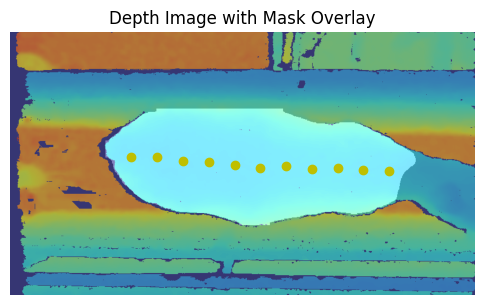

In [ ]:
def calculate_shape_features(mask, depth, floor_distance=2225):
    """Compute shape features based on the mask and depth map."""
    if mask.size == 0:
        return [0] * 7

    pred_mask = mask.astype(bool)

    # Handle invalid depth values
    invalid_cell_mask = depth == 0
    indices = nd.distance_transform_edt(invalid_cell_mask, return_distances=False, return_indices=True)
    depth_filled = depth.copy()
    depth_filled = depth_filled[tuple(indices)]

    # Set depth values outside the mask to zero
    depth_filled[~pred_mask] = 0
    depth_filled[depth_filled >= floor_distance] = 0

    # Compute depth to floor
    depth_to_floor = floor_distance - depth_filled
    depth_to_floor[depth_filled == 0] = 0

    # Compute area and volume
    focal_length = 0.6
    sensor_size = 0.0014
    f = focal_length / sensor_size
    each_pixel_area = (depth_filled / f) ** 2
    area = np.sum(each_pixel_area) * 0.01  # cm²
    volume = np.sum(each_pixel_area * depth_to_floor) * 1e-6  # L

    labeled_mask = label(pred_mask)
    properties = regionprops(labeled_mask)

    if not properties:
        return [area, volume, 0, 0, 0, 0, 0]

    prop = properties[0]
    circularity = (4 * prop.area * math.pi) / (prop.perimeter ** 2) if prop.perimeter > 0 else 0
    extent = prop.extent
    eccentricity = prop.eccentricity
    perimeter = prop.perimeter
    major_axis_length = max(np.max(np.sum(rotate(pred_mask, -prop.orientation * 180 / math.pi, resize=True), axis=1)), np.max(np.sum(rotate(pred_mask, -prop.orientation * 180 / math.pi, resize=True), axis=0)))

    return [area, volume, circularity, extent, eccentricity, perimeter, major_axis_length]

shape_features = calculate_shape_features(mask, depth)


print(shape_features)

#Step 7: Overlay Mask on Depth Image
plt.figure(figsize=(6,6))
plt.imshow(depth, cmap="jet", alpha=0.7)  # Depth map with transparency
plt.imshow(mask, cmap="gray", alpha=0.3)  # Mask overlay

# Plot center points
for cy, c in center_y_points:
    plt.plot(c, cy, 'yo')  # Yellow dots for key points

plt.title("Depth Image with Mask Overlay")
plt.axis("off")
plt.show()

#Step 8: Store Results in a DataFrame and Display It

In [ ]:
# Prepare column names dynamically
height_columns = [f"Height_{i+1}" for i in range(len(center_points))]
width_columns = [f"Width_{i+1}" for i in range(len(center_points))]

# Create a dictionary to store the structured data
df_dict = {
    "Image Name": [os.path.basename(image_path)],  # Image name as first column
}

# Add height and width data
df_dict.update({col: [height] for col, height in zip(height_columns, heights)})  # Heights first
df_dict.update({col: [width] for col, width in zip(width_columns, [w for _, _, _, _, w in center_points])})  # Widths next

# Add shape feature data
shape_feature_names = ["Area (cm²)", "Volume (L)", "Circularity", "Extent", "Eccentricity", "Perimeter (pixels)", "Major Axis Length (pixels)"]
df_dict.update({name: [value] for name, value in zip(shape_feature_names, shape_features)})

# Create DataFrame
df_results = pd.DataFrame(df_dict)
